### Tinkering around with initial testing. Mostly, I am trying to answer question (b).

In [87]:


def S_o_next(beta_o, S_o_curr, I_curr_o, I_curr_m):
    return -beta_o*S_o_curr * (I_curr_o + I_curr_m)

def S_m_next(beta_m, S_m_curr, I_curr_o, I_curr_m):
    return -beta_m*S_m_curr * (I_curr_o + I_curr_m)

def R_o_next(k, R_o_curr):
    return k * R_o_curr

def R_m_next(k, R_m_curr):
    return k * R_m_curr

def I_o_next(beta_o, S_o_curr, I_curr_o, I_curr_m, k, R_o_curr):
    return (beta_o*S_o_curr * (I_curr_o + I_curr_m)) - (k * R_o_curr)

def I_m_next(beta_m, S_m_curr, I_curr_o, I_curr_m, k, R_m_curr):
    return (beta_m*S_m_curr * (I_curr_o + I_curr_m)) - (k * R_m_curr)



In [3]:
import numpy as np

In [23]:
.02 * 2

0.04

In [238]:
eps = 0.001 # Fraction of initially 'misinformed'
x = .8       # Fraction of 'ordinary'

step_size = .01 # step size
all_steps = np.arange(0,1+step_size,step_size)
print(f"num time steps = {len(all_steps)}")

### Set initial values ###
S_o = np.zeros(len(all_steps))
S_m = np.zeros(len(all_steps))
I_o = np.zeros(len(all_steps))
I_m = np.zeros(len(all_steps))
R_o = np.zeros(len(all_steps))
R_m = np.zeros(len(all_steps))

# These have unique values for the first time step
S_o[0] = x
S_m[0] = 1 - x - eps
I_m[0] = eps

recovery_days = 2
k = 1/recovery_days


B_o = .2
B_m = B_o*2
print(B_o)
print(B_m)
avg_beta = (B_o+B_m)/2
print('avg beta', avg_beta)
print('k',k)
print('R_0',avg_beta/k)
print("~~~")

print(((B_o+B_m)/2) / k)
print(B_o/k)
print(B_m/k)


for t in range(0, len(all_steps)-1):
    d_s_o = S_o_next(
        beta_o = B_o,
        S_o_curr = S_o[t],
        I_curr_o = I_o[t],
        I_curr_m = I_m[t]
    )
    d_s_m = S_m_next(
        beta_m = B_m,
        S_m_curr = S_m[t],
        I_curr_o = I_o[t],
        I_curr_m = I_m[t]
    )
    d_i_o = I_o_next(
        beta_o = B_o,
        S_o_curr = S_o[t],
        I_curr_o = I_o[t],
        I_curr_m = I_m[t],
        k = k,
        R_o_curr = R_o[t]
    )
    d_i_m = I_m_next(
        beta_m = B_m,
        S_m_curr = S_m[t],
        I_curr_o = I_o[t],
        I_curr_m = I_m[t],
        k = k,
        R_m_curr = R_m[t]
    )
    
    d_r_o = R_o_next(k=k, R_o_curr=R_o[t])
    d_r_m = R_m_next(k=k, R_m_curr=R_m[t])
    
    total_change = d_s_o + d_s_m + d_i_o + d_i_m + d_r_o + d_r_m
    
    assert np.allclose(total_change, 0), f"{total_change}"
    
    S_o[t+1] = S_o[t] + d_s_o
    
    S_m[t+1] = S_m[t] + d_s_m
    
    I_o[t+1] = I_o[t] + d_i_o
    
    I_m[t+1] = I_m[t] + d_i_m
    
    R_o[t+1] = R_o[t] + d_r_o
    R_m[t+1] = R_m[t] + d_r_m
    

    
all_results = np.stack([
    S_o, S_m, I_o, I_m, R_o, R_m
]).T

df = pd.DataFrame(
    all_results,
    columns = [
        'susceptible_ord',
        'susceptible_misinfo',
        'infected_ord',
        'infected_misinfo',
        'recovered_ord',
        'recovered_misinfo',
    ]
)

df['steps'] = all_steps

# df = df[['steps','infected_ord','infected_misinfo']]

# df['all_infected'] = df['infected_ord'] + df['infected_misinfo']

alt.Chart(df.melt(id_vars='steps')).mark_line().encode(
    x = alt.X(
        'steps:Q',
        title = f"Time step ({step_size})"
    ),
    y = alt.Y(
        'value:Q',
        title = "Proportion of poulation"
    ),
    color = alt.Color(
        'variable:N'
    )
).properties(width=700, height=300)

num time steps = 101
0.2
0.4
avg beta 0.30000000000000004
k 0.5
R_0 0.6000000000000001
~~~
0.6000000000000001
0.4
0.8


alt.Chart(...)

In [219]:
(B_o+B_m)/2

0.30000000000000004

In [220]:
k

0.1

In [101]:
import matplotlib.pyplot as plt
import pandas as pd

In [180]:
B_o = .02
B_m = lambda x : x*2

In [178]:
B_os = np.arange(.001, 1, .01)

In [179]:
len(B_os)

100

In [182]:
bms = [B_m(x) for x in B_os]


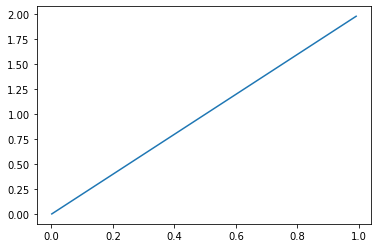

In [183]:
plt.plot(B_os, bms)

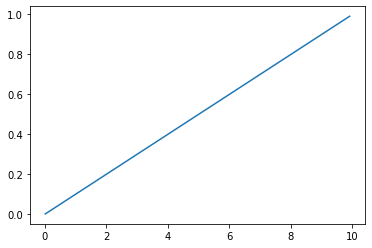

In [187]:
k = .1
plt.plot(B_os/k, B_os)

In [191]:
B_o/ .002

10.0

In [184]:
k

0.0001

In [155]:
all_results.shape

(101, 6)

In [156]:
len(I_o)

101

In [146]:
import altair as alt

In [147]:
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

,steps,variable,value
0,0.00,susceptible_ord,0.800000
1,0.01,susceptible_ord,0.799600
2,0.02,susceptible_ord,0.799032
3,0.03,susceptible_ord,0.798227
4,0.04,susceptible_ord,0.797085
...,...,...,...
601,0.96,recovered_misinfo,0.000000
602,0.97,recovered_misinfo,0.000000
603,0.98,recovered_misinfo,0.000000
604,0.99,recovered_misinfo,0.000000


alt.Chart(...)

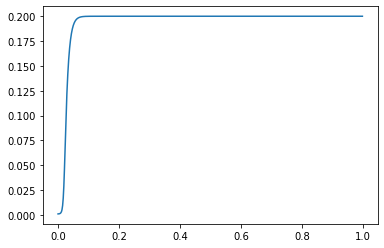

In [93]:
plt.plot(all_steps, I_m)

In [66]:
I_m[0]

0.1

In [67]:
I_o[0]

0.0

In [68]:
S_o[0]

80.0

In [69]:
S_m[0]

19.899999999999995

In [86]:
k * 

0.001

In [ ]:
R_o_next()

In [85]:
R_o

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [207]:
(I_o + I_m + R_o + R_m + S_o + S_m)

array([1., 1., 1., ..., 1., 1., 1.])

In [40]:
for x in I_o:
    print(x)

0.0
0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0

-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0


-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0


-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0


In [21]:
all_steps[-1]

1.0

In [22]:
all_steps[0]

0.0